In [66]:
# %pip install nbformat

In [67]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [68]:
%run ml_project_normalized.ipynb

Note: you may need to restart the kernel to use updated packages.
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [69]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [70]:
# Trying to figure out SMOTE
from imblearn.over_sampling import SMOTE, SMOTENC
#df_train_downsample.head()

In [71]:
df_train.head()#['breed'].value_counts()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,intake_month,intake_hour,primary_color,is_mix,outcome_type
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,4,2015,7,12,white,0,Return to Owner
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,6,2016,4,18,sable,1,Return to Owner
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,5,0,orange,0,Transfer
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,4,2017,2,12,chocolate,1,Return to Owner
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,0,2019,4,9,black,1,Return to Owner


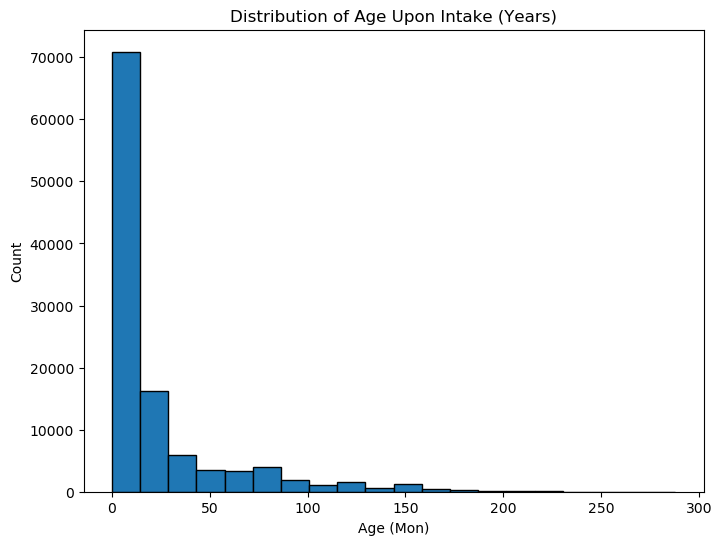

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_train['age_upon_intake'].dropna(), bins=20, edgecolor='black')
plt.title("Distribution of Age Upon Intake (Years)")
plt.xlabel("Age (Mon)")
plt.ylabel("Count")

plt.show()

In [73]:
age_bins = [0, 3, 6, 12, 24, 36, 60, 96, 144, 192, 300]  # now 11 bin edges → 10 bins
age_labels = [
    '0–3 mo',    # baby
    '3–6 mo',    # older baby
    '6–12 mo',   # adolescent
    '1–2 yr',    # young adult
    '2–3 yr',    
    '3–5 yr',    
    '5–8 yr',    
    '8–12 yr',   
    '12–16 yr',  
    '16–25 yr'   # older adult, extends to 25 yrs max
]

df_train['age_group'] = pd.cut(df_train['age_upon_intake'], bins=age_bins, labels=age_labels, right=False)
df_train['age_group'].value_counts()

0–3 mo      37772
2–3 yr      16192
1–2 yr      15782
3–5 yr       9351
3–6 mo       9281
6–12 mo      8056
5–8 yr       7357
8–12 yr      5073
12–16 yr     1979
16–25 yr      312
Name: age_group, dtype: int64

In [74]:
df_train = bucket_seasons(df_train)
df_train = df_train.drop(columns='intake_month')


In [88]:
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,breed,intake_year,intake_hour,primary_color,is_mix,outcome_type,age_group,season
0,Stray,Normal / Behavior,Dog,Spayed Female,4,2015,12,white,0,Return to Owner,8–12 yr,Summer
1,Stray,Normal / Behavior,Dog,Intact Male,6,2016,18,sable,1,Return to Owner,6–12 mo,Spring
2,Public Assist,Normal / Behavior,Cat,Neutered Male,Common,2022,0,orange,0,Transfer,2–3 yr,Spring
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,4,2017,12,chocolate,1,Return to Owner,2–3 yr,Winter
4,Public Assist,Normal / Behavior,Dog,Neutered Male,0,2019,9,black,1,Return to Owner,5–8 yr,Spring


In [76]:
# Convert all object and categorical columns to strings
for col in df_train.select_dtypes(include=['object', 'category']).columns:
    df_train[col] = df_train[col].astype(str)

df_train = df_train.drop(columns=['age_upon_intake'])
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,breed,intake_year,intake_hour,primary_color,is_mix,outcome_type,age_group,season
0,Stray,Normal / Behavior,Dog,Spayed Female,4,2015,12,white,0,Return to Owner,8–12 yr,Summer
1,Stray,Normal / Behavior,Dog,Intact Male,6,2016,18,sable,1,Return to Owner,6–12 mo,Spring
2,Public Assist,Normal / Behavior,Cat,Neutered Male,Common,2022,0,orange,0,Transfer,2–3 yr,Spring
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,4,2017,12,chocolate,1,Return to Owner,2–3 yr,Winter
4,Public Assist,Normal / Behavior,Dog,Neutered Male,0,2019,9,black,1,Return to Owner,5–8 yr,Spring


In [82]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

def train_CNB_classifier(X_train, y_train, X_test):

   # cat_features = ['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'intake_year','intake_month	intake_hour	primary_color	is_mix']

    pipeline = Pipeline([
      #  ('smote', SMOTENC(categorical_features=cat_features, random_state=42)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
        ('CNB', CategoricalNB())
    ])

    param_distributions = {
        "CNB__alpha": [0.1, 0.5, 1, 2, 5, 7, 10, 12, 15],
    }

    randomized_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=param_distributions,
        n_iter=5,
        cv=skf, 
        scoring=balanced_acc_scorer, 
        verbose=3,
    )
    
    randomized_search.fit(X_train, y_train)
    
    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)
    
    cv_scores = cross_val_score(randomized_search.best_estimator_, X_train, y_train, cv=skf, verbose=3, scoring=balanced_acc_scorer)
    print('Generalization Balanced accuracy (via cross_val_score):', cv_scores.mean())

    test_predictions = randomized_search.predict(X_test)

    return randomized_search.best_estimator_, test_predictions


In [99]:
'''
class_prior = [0.4952, 0.0094, 0.0310, 0.1493, 0.3151]

'''
negative_values_df = df_train[(df_train < 0).any(axis=1)]
negative_values_df

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
# CV CNB
from imblearn.over_sampling import SMOTEN



X = df_train.drop(columns=['outcome_type'])
y = df_train['outcome_type']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)
'''
pipeline = ImbPipeline([
    ('smote', SMOTEN(categorical_features=[0,1,2,3,4,5,6,7,8,9,10],random_state=42)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('CNB', CategoricalNB())
])
'''

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTEN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Custom Transformer to label encode only nominal categorical variables
class LabelEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    def fit(self, X, y=None):
        return self.encoder.fit(X)

    def transform(self, X):
        return self.encoder.transform(X)

    def fit_transform(self, X, y=None):
        return self.encoder.fit_transform(X)

# Define feature groups
ordinal_features = ['intake_hour', 'intake_year']
nominal_features = ['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake',
                    'breed', 'primary_color', 'is_mix', 'age_group', 'season']


rare_classes = [
  label for label, count in pd.Series(y_train).value_counts().items()
  if count < 0.05 * len(y_train)
]
y_series        = pd.Series(y_train)
max_count       = y_series.value_counts().max()
sampling_target = {cls: max_count for cls in rare_classes}

# Preprocessing for SMOTEN: encode all categoricals
pre_smote = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(), ordinal_features),
    ('lab', LabelEncoderWrapper(), nominal_features)
])

# After SMOTEN: one-hot encode everything
post_smote = ColumnTransformer(transformers=[
  #  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ordinal_features + nominal_features)
])

# Full pipeline
pipeline = ImbPipeline([
    ('pre_smote_encoding', pre_smote),
    ('smote', SMOTEN(random_state=42, sampling_strategy=sampling_target)),
  #  ('post_smote_encoding', post_smote),
    ('CNB', CategoricalNB())
])


param_distributions = {
    "CNB__alpha": [0.1, 0.5, 1, 2, 5, 7, 10],
    'CNB__class_prior':[None, [0.4952, 0.0094, 0.0310, 0.1493, 0.3151]]
}

# Perform hyperparameter search using RandomizedSearchCV.
randomized_search = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_distributions,
    n_iter=1,
    cv=skf, 
    scoring=balanced_acc_scorer, 
    error_score='raise', 
    verbose=3,

)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

randomized_search.fit(X_train, y_train)

cv_scores = cross_val_score(randomized_search.best_estimator_, X_train, y_train, cv=5, verbose=3, scoring=balanced_acc_scorer)
# Get the predicted probabilities
y_prob = randomized_search.predict_proba(X_test)

# Adjust threshold for each class (excluding "Adopted")
# Here, we assume that class 0 corresponds to "Adopted"
# Adjust the threshold for the other 4 classes (assuming these classes are 1, 2, 3, 4)
thresholds = np.array([0.7, 0.6, 0.5, 0.5])  # Example thresholds for each non-adopted class

# Get predicted classes based on thresholds
y_pred = np.argmax(y_prob, axis=1)

# Adjust for non-adopted classes based on the new threshold
for i in range(1, len(thresholds) + 1):
    y_pred[(y_prob[:, i] >= thresholds[i-1])] = i

classification_report_with_accuracy_score(y_test, y_pred)


'''
print('Best parameters:', randomized_search.best_params_)
print('Best estimates:', randomized_search.best_estimator_)
print('Best cross-validation accuracy:', randomized_search.best_score_)

cv_scores = cross_val_score(randomized_search.best_estimator_, X_train, y_train, cv=5, verbose=3, scoring=balanced_acc_scorer)
print('Generalization Balanced accuracy (via cross_val_score):', cv_scores.mean())

test_pred_cnb = randomized_search.predict(X_test)

classification_report_with_accuracy_score(y_test, test_pred_cnb)
'''
'''
NB_conf = confusion_matrix(y_true=labels_test, y_pred=test_pred)
print("Confusion Matrix:\n", NB_conf)

# Generate classification report
report = classification_report(y_true=labels_test, y_pred=test_pred)
print("Classification Report:\n", report)
'''

/u/nneoma/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END CNB__alpha=0.1, CNB__class_prior=None;, score=0.428 total time=  12.5s
[CV 2/5] END CNB__alpha=0.1, CNB__class_prior=None;, score=0.424 total time=  12.5s


ValueError: Negative values in data passed to CategoricalNB (input X)

In [ ]:

'''
def train_MNB_classifier(X_train, y_train, X_test):


    pipeline = Pipeline([
      #  ('smote', SMOTENC(categorical_features=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10], random_state=42)),# 'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'is_mix', 'primary_color'], random_state=42)),
       # ('freq', FunctionTransformer(apply_freq_encode, validate=False)),
        ('onehot', OneHotEncoder( handle_unknown='ignore', sparse_output=True)),
        ('nb', MultinomialNB())
    ])

    # Set up parameter distributions for XGBoost.
    param_distributions = {
        "nb__alpha": [0.1,.3, .4, 0.5, 1, 2, 5, 7, 10],
    }

    # Perform hyperparameter search using RandomizedSearchCV.
    randomized_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=param_distributions,
        n_iter=1,
        cv=skf, 
        scoring=balanced_acc_scorer, 
        verbose=3,
    )

    # Set up parameter distributions for XGBoost.
    param_distributions = {
        "nb__alpha": [0.1, 0.5, 1, 2, 5, 10],
    }
    
    # Perform hyperparameter search using RandomizedSearchCV.
    randomized_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=param_distributions,
        n_iter=1,
        cv=skf, 
        scoring=balanced_acc_scorer, 
        verbose=3,
    )
    
    randomized_search.fit(X_resampled, y_resampled)
    
    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)
    
    cv_scores = cross_val_score(randomized_search.best_estimator_, X_resampled, y_resampled, cv=skf, verbose=3, scoring=balanced_acc_scorer)
    print('Generalization Balanced accuracy (via cross_val_score):', cv_scores.mean())

    # Make predictions on the test set using the best estimator.
    test_predictions = randomized_search.predict(X_test)

    
    
    return randomized_search.best_estimator_, test_predictions
    '''


In [36]:
# downsampling
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

df_train_downsample = resample(df_train, replace=False, n_samples=50000, random_state=42)
print(df_train_downsample.shape)

(50000, 10)


In [18]:
# Cross Validation MNB
practice_dog = df_train#[df_train_downsample['animal_type'] == 'Dog']
practice_dog_labels = practice_dog['outcome_type']
practice_dog_data = practice_dog.drop(columns=['outcome_type'])
practice_train, practice_test, labels_train, labels_test = train_test_split(practice_dog_data,practice_dog_labels , test_size=0.30, random_state=42)

pipeline = Pipeline([
  #  ('smote', SMOTENC(categorical_features=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11], random_state=42)),# 'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'is_mix', 'primary_color'], random_state=42)),
 #   ('freq', FunctionTransformer(apply_freq_encode, validate=False)),
    ('onehot', OneHotEncoder( handle_unknown='ignore', sparse_output=True)),
    ('nb', MultinomialNB())
])

# Set up parameter distributions for XGBoost.
param_distributions = {
    "nb__alpha": [0.1,.3, .4, 0.5, 1, 2, 5, 7, 10],
}

# Perform hyperparameter search using RandomizedSearchCV.
randomized_search = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_distributions,
    n_iter=1,
    cv=skf, 
    scoring=balanced_acc_scorer, 
    verbose=3,
)

randomized_search.fit(practice_train, labels_train)

print('Best parameters:', randomized_search.best_params_)
print('Best estimates:', randomized_search.best_estimator_)
print('Best cross-validation accuracy:', randomized_search.best_score_)

cv_scores = cross_val_score(randomized_search.best_estimator_, practice_train, labels_train, cv=5, verbose=3, scoring=balanced_acc_scorer)
print('Generalization Balanced accuracy (via cross_val_score):', cv_scores.mean())

test_pred = randomized_search.predict(practice_test)

classification_report_with_accuracy_score(labels_test, test_pred)
'''
NB_conf = confusion_matrix(y_true=labels_test, y_pred=test_pred)
print("Confusion Matrix:\n", NB_conf)

# Generate classification report
report = classification_report(y_true=labels_test, y_pred=test_pred)
print("Classification Report:\n", report)
'''


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .......................nb__alpha=0.5;, score=nan total time=   0.0s
[CV 2/5] END .......................nb__alpha=0.5;, score=nan total time=   0.0s
[CV 3/5] END .......................nb__alpha=0.5;, score=nan total time=   0.0s
[CV 4/5] END .......................nb__alpha=0.5;, score=nan total time=   0.0s
[CV 5/5] END .......................nb__alpha=0.5;, score=nan total time=   0.0s


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/_encode.py", line 174, in _unique_python
    uniques = sorted(uniques_set)
TypeError: '<' not supported between instances of 'str' and 'int'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/u/nneoma/.local/lib/python3.8/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py", line 985, in fit
    self._fit(
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py", line 98, in _fit
    result = _unique(Xi, return_counts=compute_counts)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/_encode.py", line 42, in _unique
    return _unique_python(
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/_encode.py", line 179, in _unique_python
    raise TypeError(
TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']


In [9]:
practice_dog.columns

Index(['intake_time', 'intake_type', 'intake_condition', 'animal_type',
       'sex_upon_intake', 'age_upon_intake', 'breed', 'is_mix',
       'primary_color', 'outcome_type'],
      dtype='object')

In [ ]:
# One Iteration of NB
practice_dog = df_train#[df_train_downsample['animal_type'] == 'Dog']
practice_dog_labels = practice_dog['outcome_type']
practice_dog_data = practice_dog.drop(columns=['outcome_type'])
practice_train, practice_test, labels_train, labels_test = train_test_split(practice_dog_data,practice_dog_labels , test_size=0.30, random_state=42)


smote = SMOTENC(categorical_features=['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'is_mix', 'primary_color'], random_state=42)
X_resampled, y_resampled = smote.fit_resample(practice_train, labels_train)

ft =  FunctionTransformer(apply_freq_encode, validate=False)
X_freq = ft.fit_transform(X_resampled)

oh = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_encoded = oh.fit_transform(X_freq)

nb = MultinomialNB(alpha=10)
nb.fit(X_encoded, y_resampled)

X_test_freq = ft.transform(practice_test)
X_test_encoded = oh.transform(X_test_freq)

# Predict
y_pred = nb.predict(X_test_encoded)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
classification_report_with_accuracy_score(labels_test, y_pred)

# Convert log probabilities to actual probabilities
feature_probs = np.exp(nb.feature_log_prob_)  # shape: (n_classes, n_features)


feature_names = oh.get_feature_names_out()  # after one-hot encoding


'''
pd.set_option('display.max_rows', None)       # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', None)          # No line wrapping
#pd.set_option('display.max_colwidth', None)   # Don't truncate column content
'''



# Build DataFrame: rows = features, columns = classes
feature_prob_df = pd.DataFrame(feature_probs.T, index=feature_names, columns=nb.classes_)
cleaned_df = feature_prob_df[~feature_prob_df.index.str.contains("intake_time")]
no_breed_no_color = cleaned_df[~cleaned_df.index.str.contains("primary_color")]
no_breed_no_color = no_breed_no_color[~no_breed_no_color.index.str.contains("breed")]


/tmp/ipykernel_163125/2931022905.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(freq_series)


                 precision    recall  f1-score   support

       Adoption       0.63      0.79      0.70     16619
           Died       0.06      0.12      0.08       306
     Euthanasia       0.27      0.34      0.30      1035
Return to Owner       0.48      0.58      0.53      4827
       Transfer       0.69      0.31      0.43     10560

       accuracy                           0.59     33347
      macro avg       0.43      0.43      0.41     33347
   weighted avg       0.61      0.59      0.57     33347



,Adoption,Died,Euthanasia,Return to Owner,Transfer
intake_type_Abandoned,0.000177,0.000004,0.000014,0.000063,0.000110
intake_type_Euthanasia Request,0.000005,0.000004,0.000328,0.000005,0.000007
intake_type_Owner Surrender,0.003165,0.001398,0.001888,0.000749,0.002060
intake_type_Public Assist,0.000264,0.000015,0.000580,0.002954,0.000272
intake_type_Stray,0.008976,0.011164,0.009775,0.008814,0.010138
...,...,...,...,...,...
age_upon_intake_21.151482982566677,0.000003,0.000003,0.000003,0.000004,0.000003
age_upon_intake_22.0,0.000003,0.000003,0.000003,0.000004,0.000003
age_upon_intake_24.0,0.000003,0.000003,0.000003,0.000004,0.000003
is_mix_0,0.004947,0.005088,0.003541,0.004463,0.004356


In [17]:
no_breed_no_color.iloc[60:, :]

,Adoption,Died,Euthanasia,Return to Owner,Transfer
age_upon_intake_0.0002300549036006838,0.000003,0.000004,0.000003,0.000003,0.000003
age_upon_intake_0.0002373323443590971,0.000003,0.000004,0.000003,0.000003,0.000003
age_upon_intake_0.0002378207571990604,0.000003,0.000004,0.000003,0.000003,0.000003
age_upon_intake_0.00024073379689816099,0.000003,0.000004,0.000003,0.000003,0.000003
age_upon_intake_0.00024083506444665115,0.000003,0.000004,0.000003,0.000003,0.000003
...,...,...,...,...,...
age_upon_intake_21.151482982566677,0.000003,0.000003,0.000003,0.000004,0.000003
age_upon_intake_22.0,0.000003,0.000003,0.000003,0.000004,0.000003
age_upon_intake_24.0,0.000003,0.000003,0.000003,0.000004,0.000003
is_mix_0,0.004947,0.005088,0.003541,0.004463,0.004356


In [ ]:
from sklearn.preprocessing import LabelEncoder
# For Dog:
'''
train_dog = df_train_downsample[df_train_downsample['animal_type'] == 'Dog'].copy()
X_train_dog = train_dog.drop(columns=['animal_type', 'outcome_type'])
y_train_dog = train_dog['outcome_type']

test_dog = df_test[df_test['animal_type'] == 'Dog'].copy()
X_test_dog = test_dog.drop(columns=['animal_type'])

# For Cat:
train_cat = df_train_downsample[df_train_downsample['animal_type'] == 'Cat'].copy()
X_train_cat = train_cat.drop(columns=['animal_type', 'outcome_type'])
y_train_cat = train_cat['outcome_type']

test_cat = df_test[df_test['animal_type'] == 'Cat'].copy()
X_test_cat = test_cat.drop(columns=['animal_type'])

## Encode targets with LabelEncoder
# Dog encoding
le_dog = LabelEncoder()
y_train_dog_encoded = le_dog.fit_transform(y_train_dog)

# Cat encoding
le_cat = LabelEncoder()
y_train_cat_encoded = le_cat.fit_transform(y_train_cat)
'''

'''
print("Training model for Dog data:")
best_estimator_dog, dog_predictions_encoded = train_NB_classifier(X_train_dog, y_train_dog_encoded, X_test_dog)
dog_predictions = le_dog.inverse_transform(dog_predictions_encoded)

'''
# Don't split cat and dog
X_train = df_train.drop(columns=['outcome_type'])
y_train = df_train['outcome_type']

X_test = df_test

le_train = LabelEncoder()
y_train_encoded = le_train.fit_transform(y_train)


print("\nTraining model")
best_estimator, predictions_encoded = train_NB_classifier(X_train, y_train_encoded, X_test)
predictions = le_train.inverse_transform(predictions_encoded)


save_predictions(predictions, "NB")
print("DONE!\n", best_estimator)



Training model


KeyboardInterrupt: 